# IEEE-CIS Fraud Detection - data analisys

    Detailed infomation about competition:
https://www.kaggle.com/c/ieee-fraud-detection/overview

    Data analitycs for the competition dataset
    Done before modelling for features investigation and finding logical correlations

Importing libs, ignoring all warnings, defining plots style and color palette

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter('ignore')
plt.style.use('seaborn-dark')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

    Data import

Train datasets:
- train_identity.csv -- shape(144233, 41) -- additional dataset, connected with transactions by TransactionID
- train_transaction.csv -- shape(590540, 394) -- main dataset with transactional history

Test datasets:
- test_identity.csv -- shape(141907, 41)
- test_transaction.csv -- shape(506691, 393)

Finals:
- sample_submission.csv -- submission finals file

In [3]:
train_identity = pd.read_csv('../Input/ieee-fraud-detection/train_identity.csv')
train_transaction = pd.read_csv('../Input/ieee-fraud-detection/train_transaction.csv')
test_identity = pd.read_csv('../Input/ieee-fraud-detection/test_identity.csv')
test_transaction = pd.read_csv('../Input/ieee-fraud-detection/test_transaction.csv')
ss = pd.read_csv('../Input/ieee-fraud-detection/sample_submission.csv')

    Check datasets intersection 

In [4]:
print('train datasets intersect in {}% of transactions'\
      .format(np.sum(train_transaction['TransactionID']\
                     .isin(train_identity['TransactionID']\
                           .unique()))/train_transaction['TransactionID'].count()))

print('test datasets intersect in {}% of transactions'\
      .format(np.sum(test_transaction['TransactionID']\
                     .isin(test_identity['TransactionID']\
                           .unique()))/test_transaction['TransactionID'].count()))

train datasets intersect in 0.2442391709283029% of transactions
test datasets intersect in 0.28006615471756946% of transactions


    Time distribution for Train and Test datasets
- looks like it is a consequent time periods - train from earlier period of time, test from later

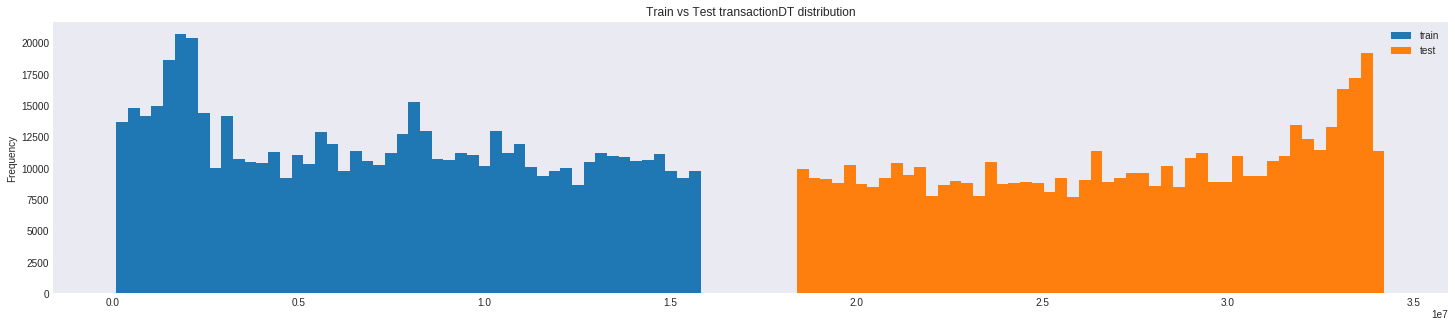

In [5]:
train_transaction['TransactionDT'].plot(kind = 'hist', figsize = (25,5), label = 'train', bins = 50,
                                       title = 'Train vs Test transactionDT distribution')
test_transaction['TransactionDT'].plot(kind='hist', label = 'test', bins=50)
plt.legend()
plt.show()

    Visualizing the fraud share in train data + distribution of train vs test

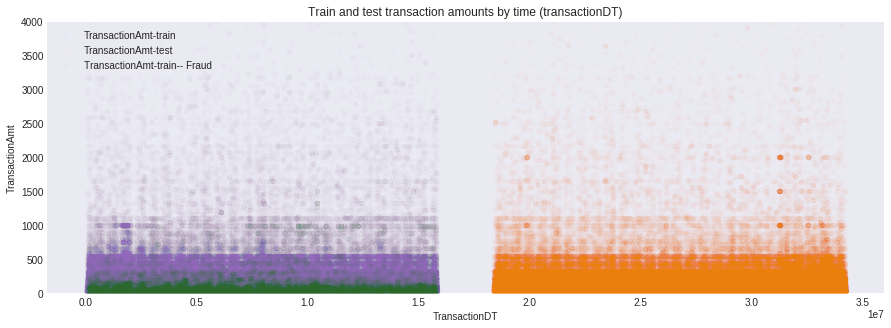

In [6]:
ax = train_transaction.plot(x='TransactionDT',
                           y='TransactionAmt',
                           kind='scatter',
                           alpha=0.01,
                           label='TransactionAmt-train',
                           title='Train and test transaction amounts by time (transactionDT)',
                           ylim=(0,4000),
                           color=color_pal[4],
                           figsize = (15,5))
test_transaction.plot(x='TransactionDT',
                           y='TransactionAmt',
                           kind='scatter',
                           alpha=0.01,
                           label='TransactionAmt-test',
                           color=color_pal[1],
                           ylim=(0,4000),
                           ax=ax)

#Fraud
train_transaction.loc[train_transaction['isFraud']==1]\
.plot(x='TransactionDT',
      y='TransactionAmt',
      kind='scatter',
      alpha=0.01,
      label='TransactionAmt-train-- Fraud',
      title='Train and test transaction amounts by time (transactionDT)',
      ylim=(0,4000),
      figsize = (15,5),
      color=color_pal[2],
      ax=ax)

plt.show()

    Percentage of fraud in train dataset

In [7]:
print('{:.2f}%'.format(train_transaction['isFraud'].mean()*100))

3.50%


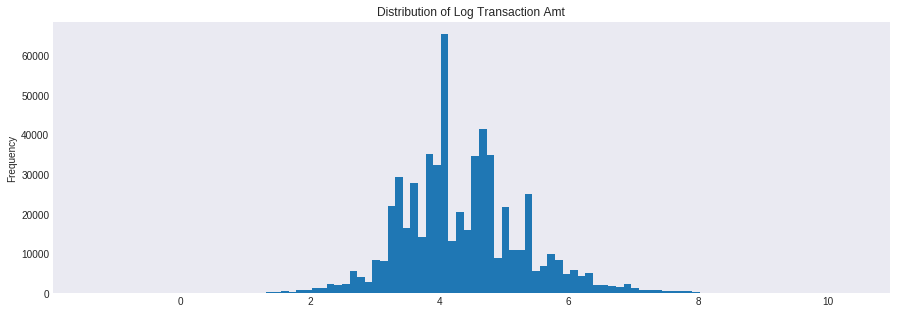

In [8]:
train_transaction['TransactionAmt'].apply(np.log).plot(kind='hist'
                                                       ,bins=100
                                                       ,figsize=(15,5)
                                                       ,title='Distribution of Log Transaction Amt')
plt.show()

    The log interpretation of the results was taken due to some high values which caused a skew (two below).
    The Fraudulent transactions has bigger mean and median, as it shown below.

the median for Fraudulent transactions is:75.0, mean is: 149.2447785897534
the median for Non Fraudulent transactions is:68.5, mean is: 134.51166457896034


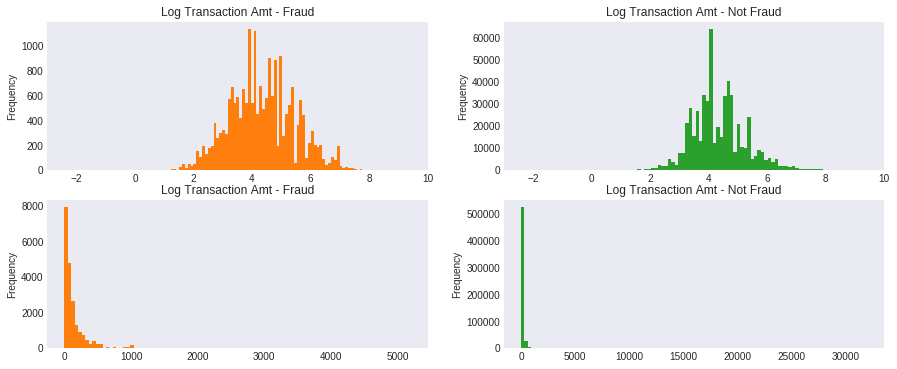

In [9]:
print(r'the median for Fraudulent transactions is:{}, mean is: {}'.format(\
train_transaction.loc[train_transaction['isFraud']==1]['TransactionAmt'].median(),
train_transaction.loc[train_transaction['isFraud']==1]['TransactionAmt'].mean()))

print(r'the median for Non Fraudulent transactions is:{}, mean is: {}'.format(\
train_transaction.loc[train_transaction['isFraud']==0]['TransactionAmt'].median(),
train_transaction.loc[train_transaction['isFraud']==0]['TransactionAmt'].mean()))
      
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(15,6))
train_transaction.loc[train_transaction['isFraud']==1]\
['TransactionAmt'].apply(np.log).plot(kind='hist',
                                        bins=100,
                                        title='Log Transaction Amt - Fraud',
                                        color=color_pal[1],
                                        xlim=(-3,10),
                                        ax=ax1)
train_transaction.loc[train_transaction['isFraud']==0]\
['TransactionAmt'].apply(np.log).plot(kind='hist',
                                        bins=100,
                                        title='Log Transaction Amt - Not Fraud',
                                        color=color_pal[2],
                                        xlim=(-3,10),
                                        ax=ax2)
train_transaction.loc[train_transaction['isFraud']==1]\
['TransactionAmt'].plot(kind='hist',
                        bins=100,
                        title='Log Transaction Amt - Fraud',
                        color=color_pal[1],
                        ax=ax3)
train_transaction.loc[train_transaction['isFraud']==0]\
['TransactionAmt'].plot(kind='hist',
                        bins=100,
                        title='Log Transaction Amt - Not Fraud',
                        color=color_pal[2],
                        ylim = 500,
                        ax=ax4)
plt.show()

# Categorical Features - Transaction

    ProductCD
The most of the observations have ProductCD = 'W'

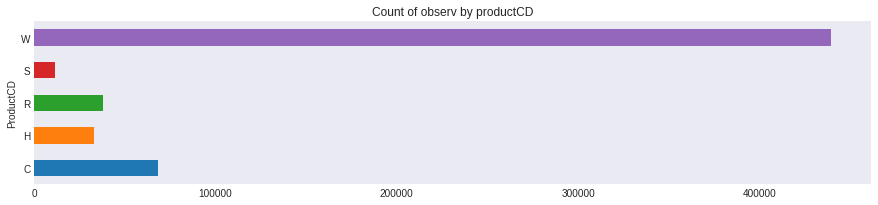

In [10]:
train_transaction.groupby('ProductCD')['TransactionID']\
.count().sort_index().plot(kind='barh'
                           ,figsize=(15,3)
                           ,title='Count of observ by productCD')
plt.show()

The highest share of fraud is in 'C' product. Therefore we can assume the correlation between mean TransactionAmt and share of fraud

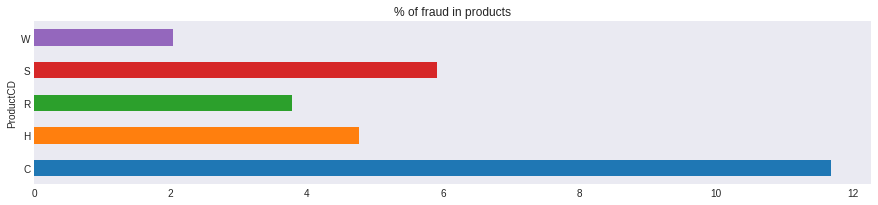

In [11]:
(train_transaction.groupby('ProductCD')['isFraud'].mean()*100).sort_index().plot(kind='barh',
                                                                           figsize=(15,3),
                                                                          title = '% of fraud in products')
plt.show()

there we see that no correlation exist 

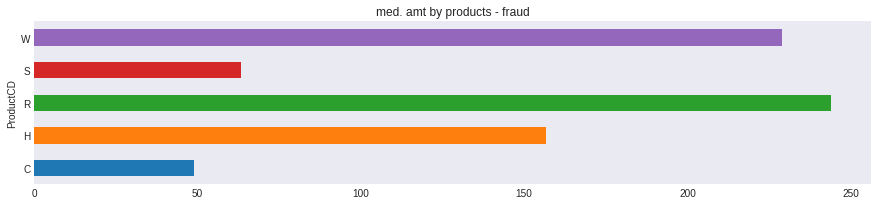

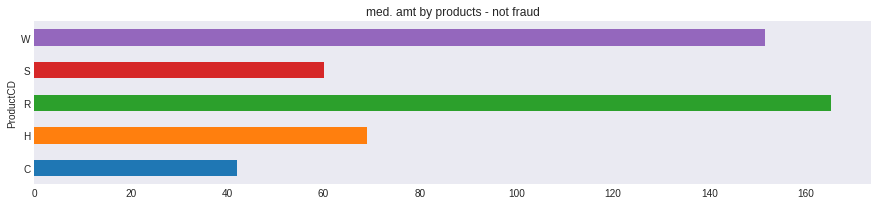

In [12]:
train_transaction.loc[train_transaction['isFraud']==1]\
.groupby('ProductCD')['TransactionAmt'].mean().sort_index().plot(kind='barh',
                                                                 figsize=(15,3),
                                                                 title='med. amt by products - fraud')
plt.show()

train_transaction.loc[train_transaction['isFraud']==0]\
.groupby('ProductCD')['TransactionAmt'].mean().sort_index().plot(kind='barh',
                                                                 figsize=(15,3),
                                                                 title='med. amt by products - not fraud')
plt.show()

# Categorical features - Card(1-6)

    since there are two non-numerical features - we will analize them later 

In [13]:
print(train_transaction[[c for c in train_transaction.columns if 'card' in c]].head(10))

   card1  card2  card3       card4  card5   card6
0  13926    NaN  150.0    discover  142.0  credit
1   2755  404.0  150.0  mastercard  102.0  credit
2   4663  490.0  150.0        visa  166.0   debit
3  18132  567.0  150.0  mastercard  117.0   debit
4   4497  514.0  150.0  mastercard  102.0  credit
5   5937  555.0  150.0        visa  226.0   debit
6  12308  360.0  150.0        visa  166.0   debit
7  12695  490.0  150.0        visa  226.0   debit
8   2803  100.0  150.0        visa  226.0   debit
9  17399  111.0  150.0  mastercard  224.0   debit


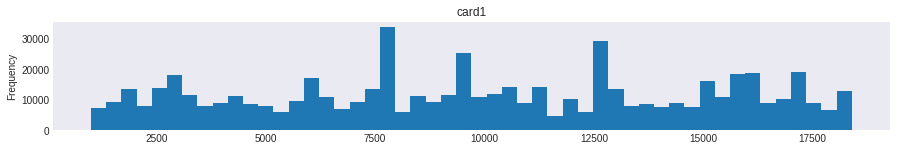

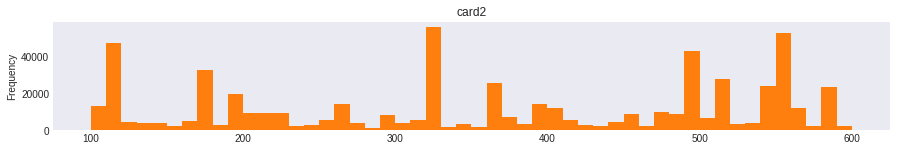

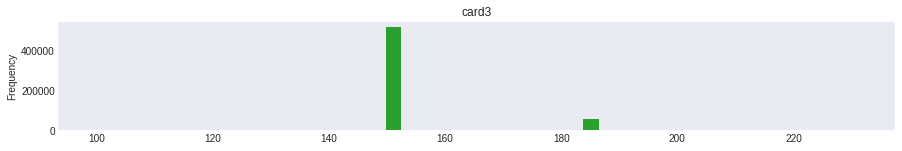

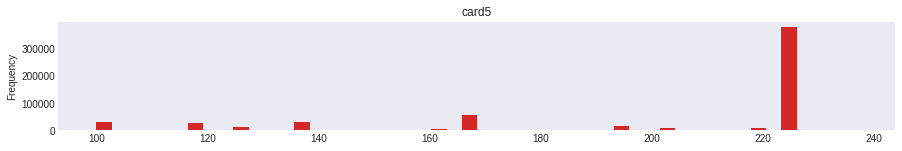

In [14]:
card_cols = [c for c in train_transaction.columns if 'card' in c]
color_idx = 0
for c in card_cols:
    if train_transaction[c].dtype in ['float64','int64']:
        train_transaction[c].plot(kind='hist',
                                 title=c,
                                 bins=50,
                                 figsize=(15,2),
                                 color=color_pal[color_idx])
        color_idx+=1
        plt.show()

    Almost the same distribution number of transactions within card4 feature. 
    The most of fraudulent transactions have card6 = 'debit'

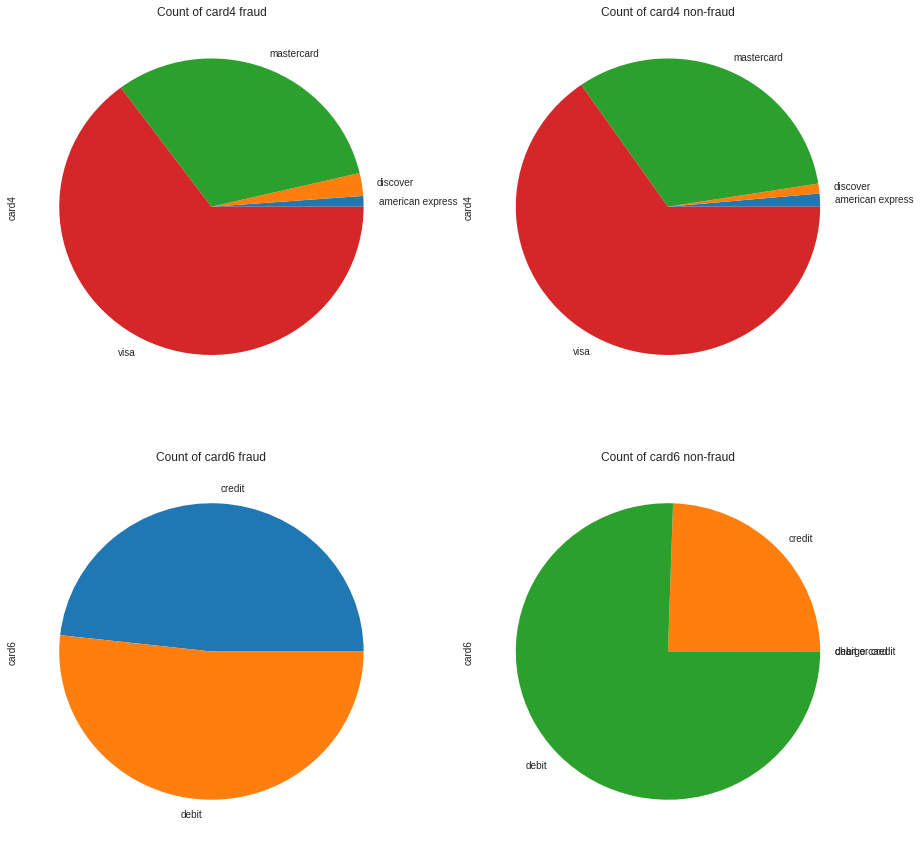

In [15]:
train_transaction_fr = train_transaction.loc[train_transaction['isFraud'] == 1]
train_transaction_nofr = train_transaction.loc[train_transaction['isFraud'] == 0]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
train_transaction_fr.groupby('card4')['card4'].count().plot(kind='pie', ax=ax1, title='Count of card4 fraud')
train_transaction_nofr.groupby('card4')['card4'].count().plot(kind='pie', ax=ax2, title='Count of card4 non-fraud')
train_transaction_fr.groupby('card6')['card6'].count().plot(kind='pie', ax=ax3, title='Count of card6 fraud')
train_transaction_nofr.groupby('card6')['card6'].count().plot(kind='pie', ax=ax4, title='Count of card6 non-fraud')
plt.show()

# Categorical features - addr(1-2)

In [16]:
print(' addr1 - has {} NA values'.format(train_transaction['addr1'].isna().sum()))
print(' addr2 - has {} NA values'.format(train_transaction['addr2'].isna().sum()))

 addr1 - has 65706 NA values
 addr2 - has 65706 NA values


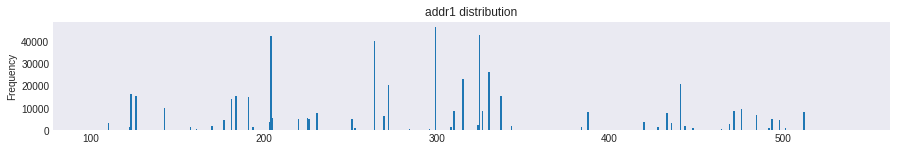

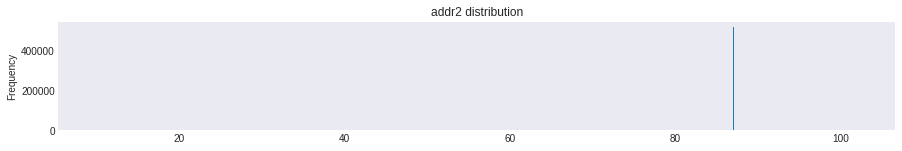

In [17]:
train_transaction['addr1'].plot(kind='hist', bins=500, figsize=(15, 2), title='addr1 distribution')
plt.show()
train_transaction['addr2'].plot(kind='hist', bins=500, figsize=(15, 2), title='addr2 distribution')
plt.show()

# Categorical features - dist(1-2)

    Slight differences in distributions in dist1 for fraudulent and non-fraudulent transactions

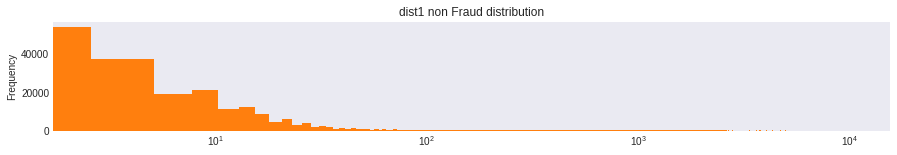

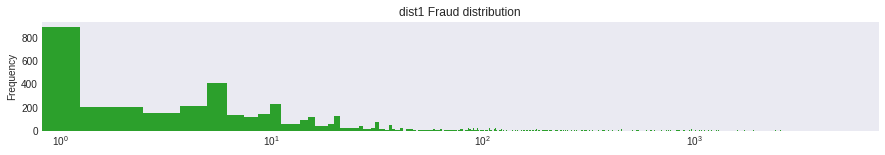

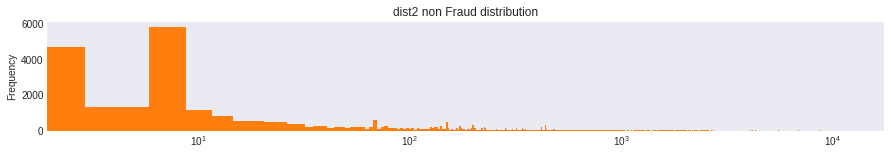

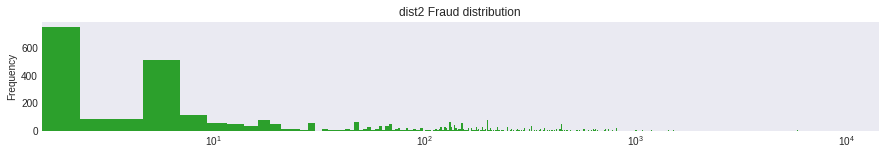

In [18]:
train_transaction.loc[train_transaction['isFraud']==0]['dist1'].plot(kind='hist',
                                                                        bins=4000,
                                                                        figsize=(15, 2),
                                                                        title='dist1 non Fraud distribution',
                                                                        color=color_pal[1] 
                                                                        ,logx=True
                                                                        )
plt.show()

train_transaction.loc[train_transaction['isFraud']==1]['dist1'].plot(kind='hist',
                                                                        bins=4000,
                                                                        figsize=(15, 2),
                                                                        title='dist1 Fraud distribution',
                                                                        color=color_pal[2] 
                                                                        ,logx=True
                                                                        )
plt.show()

train_transaction.loc[train_transaction['isFraud']==0]['dist2'].plot(kind='hist',
                                                                        bins=4000,
                                                                        figsize=(15, 2),
                                                                        title='dist2 non Fraud distribution',
                                                                        color=color_pal[1]
                                                                        ,logx=True
                                                                        )

plt.show()

train_transaction.loc[train_transaction['isFraud']==1]['dist2'].plot(kind='hist',
                                                                        bins=4000,
                                                                        figsize=(15, 2),
                                                                        title='dist2 Fraud distribution',
                                                                        color=color_pal[2]
                                                                        ,logx=True
                                                                        )

plt.show()

# Categorical features - C(1-14)

    All of them are numerical and to distract from their number we can use pair plots. 
    For better performance we will choose sample of 300 records for both Fraudulent and non-fraudulent transactions and mix them up

In [19]:
c_cols = [c for c in train_transaction if c[0] == 'C']
train_transaction[c_cols].head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


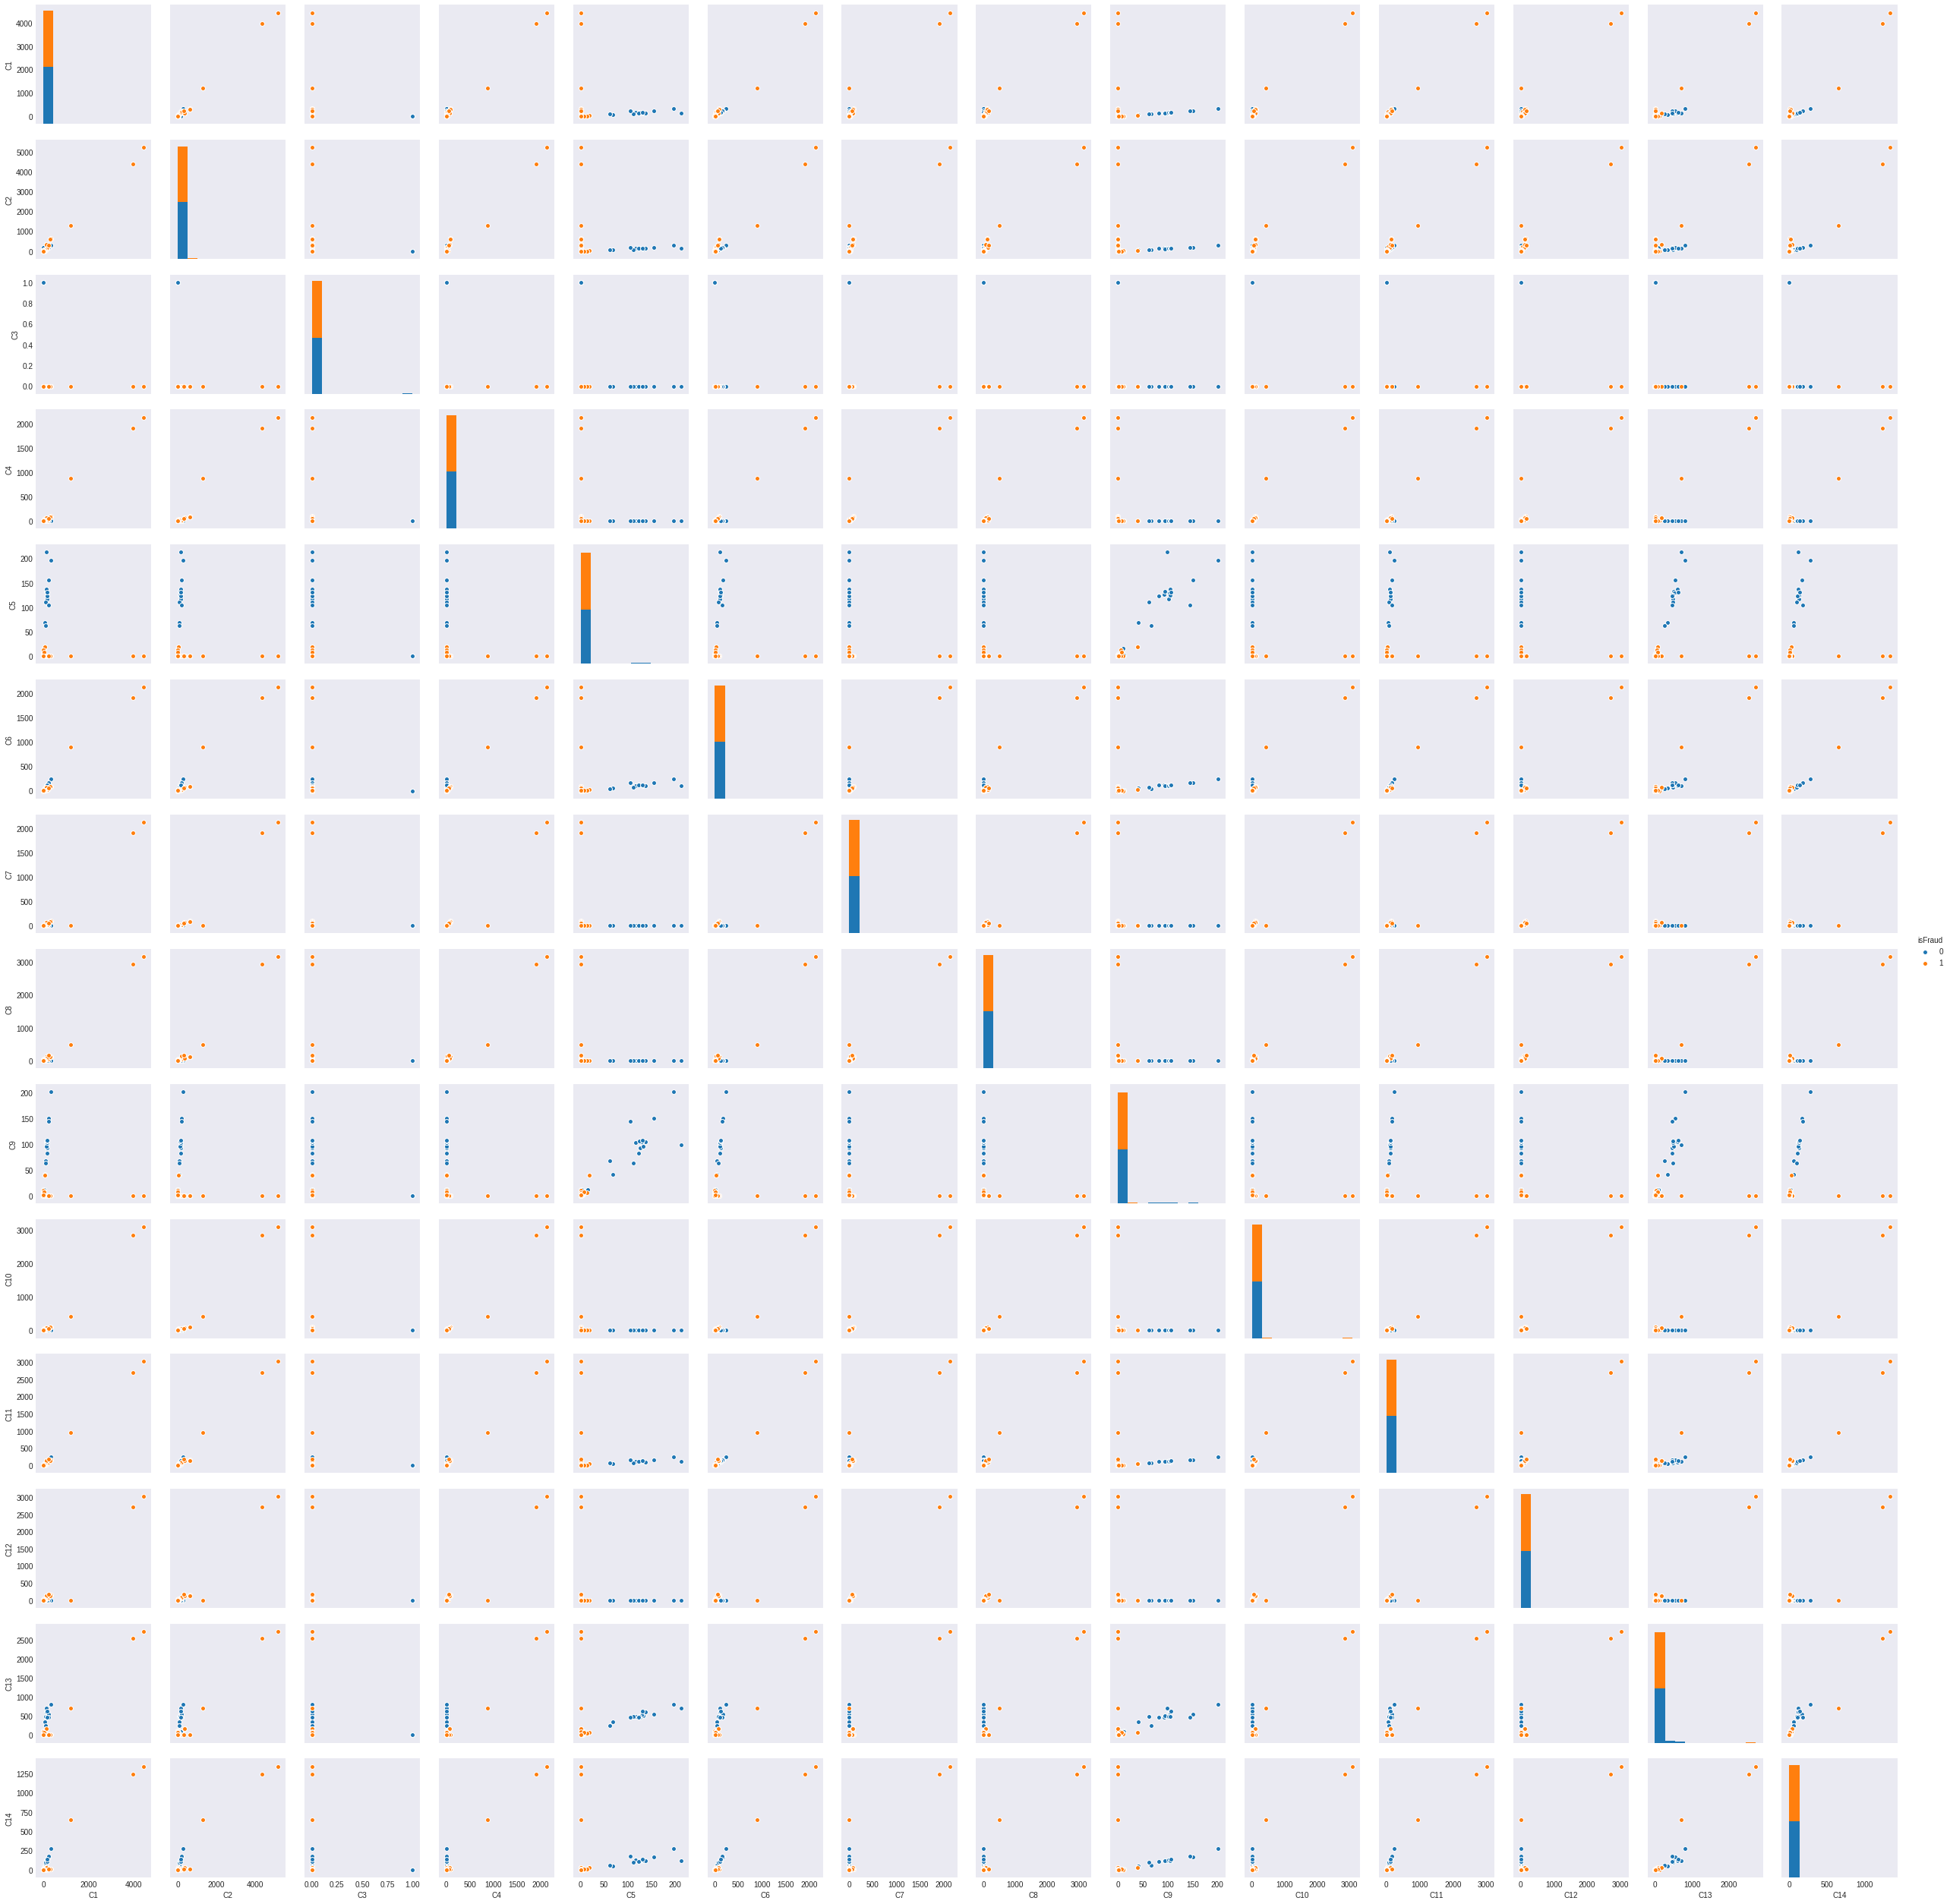

In [20]:
sampled_train = pd.concat([train_transaction.loc[train_transaction['isFraud'] == 0].sample(300),
          train_transaction.loc[train_transaction['isFraud'] == 1].sample(300)])

sns.pairplot(sampled_train, hue='isFraud', vars=c_cols)
plt.show()

# Categorical features - D (1-15)

In [21]:
d_cols = [c for c in train_transaction if c[0] == 'D']
train_transaction[d_cols].head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0
1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0
3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


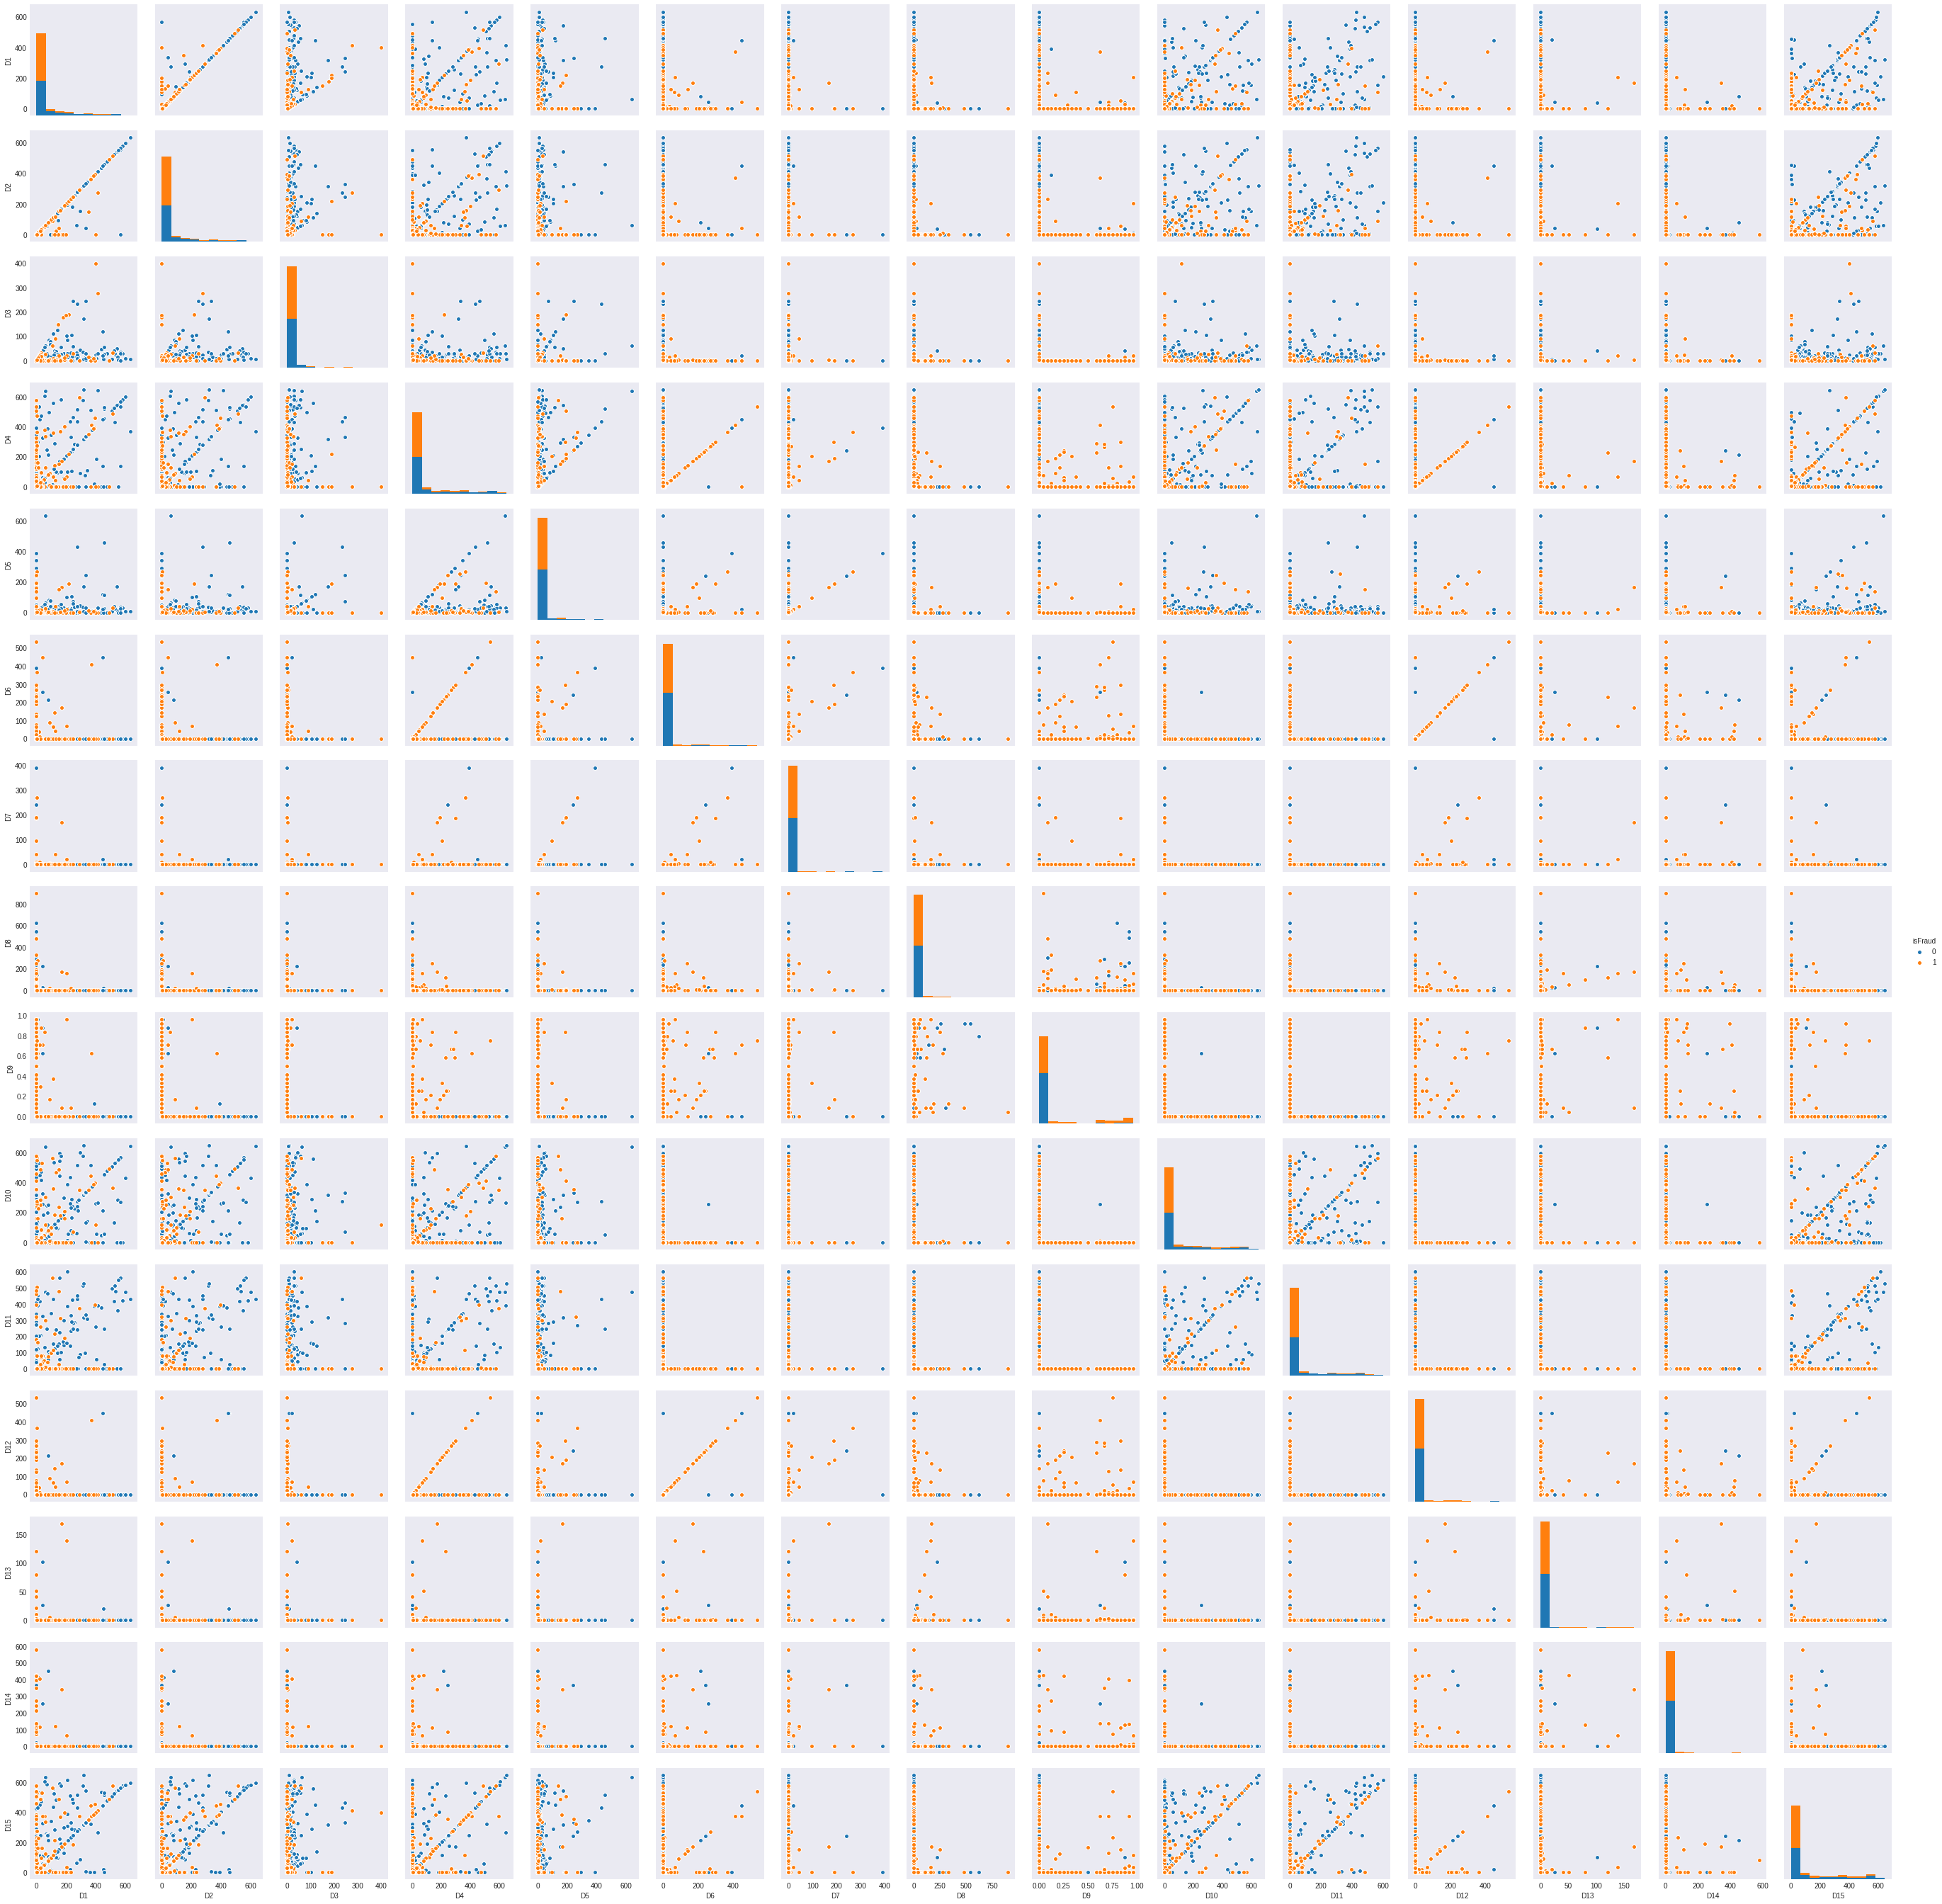

In [22]:
sns.pairplot(sampled_train.replace(np.nan, 0), 
             hue='isFraud',
             vars=d_cols)
plt.show()

# Categorical features - m(1-9) 

In [23]:
m_cols = [c for c in train_transaction if c[0] == 'M']
train_transaction[m_cols].head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,T,T,T,M2,F,T,NaN,NaN,NaN
1,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,T,T,T,M0,F,F,F,F,F
3,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


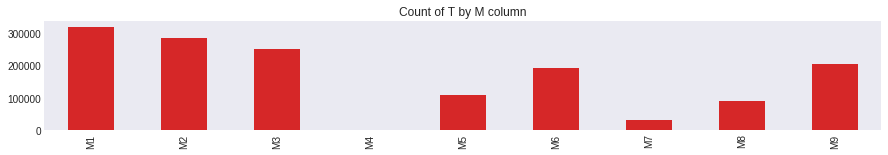

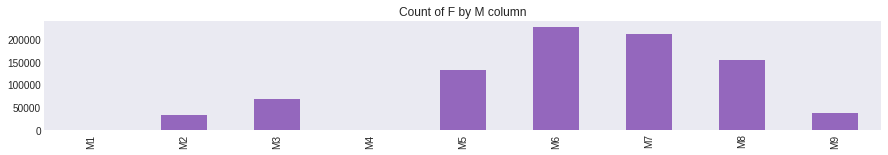

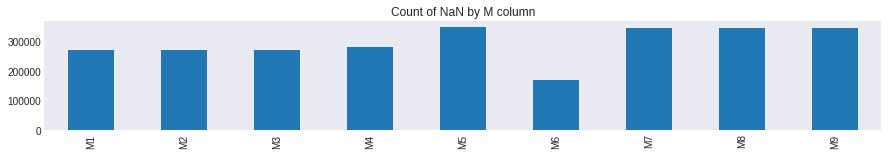

In [24]:
(train_transaction[m_cols] == 'T').sum().plot(kind='bar',
                                              title='Count of T by M column',
                                              figsize=(15, 2),
                                              color=color_pal[3])
plt.show()
(train_transaction[m_cols] == 'F').sum().plot(kind='bar',
                                              title='Count of F by M column',
                                              figsize=(15, 2),
                                              color=color_pal[4])
plt.show()
(train_transaction[m_cols].isna()).sum().plot(kind='bar',
                                              title='Count of NaN by M column',
                                              figsize=(15, 2),
                                              color=color_pal[0])
plt.show()


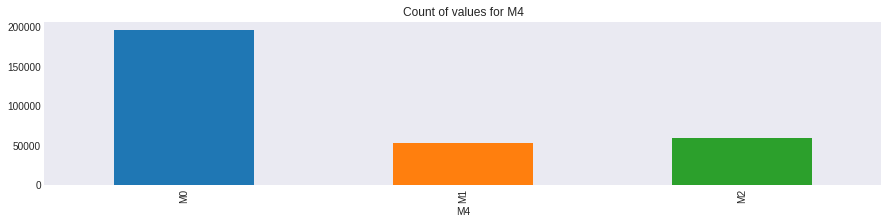

In [25]:
train_transaction.groupby('M4')['TransactionID'] \
    .count() \
    .plot(kind='bar',
          title='Count of values for M4',
          figsize=(15, 3))
plt.show()

# Categorical features - V(1-339)

In [26]:
v_cols = [c for c in train_transaction if c[0] == 'V']
train_transaction[v_cols].head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
train_transaction[v_cols].describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,...,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.00000,82351.000000,82351.000000,82351.000000,82351.000000
mean,0.999945,1.045204,1.078075,0.846456,0.876991,1.045686,1.072870,1.027704,1.041529,0.463915,...,0.775874,721.741883,1375.783644,1014.622782,9.807015,59.16455,28.530903,55.352422,151.160542,100.700882
std,0.007390,0.240133,0.320890,0.440053,0.475902,0.239385,0.304779,0.186069,0.226339,0.521522,...,4.727971,6217.223583,11169.275702,7955.735482,243.861391,387.62948,274.576920,668.486833,1095.034387,814.946722
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,25.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,1.000000,8.000000,9.000000,6.000000,6.000000,9.000000,9.000000,8.000000,8.000000,4.000000,...,55.000000,160000.000000,160000.000000,160000.000000,55125.000000,55125.00000,55125.000000,104060.000000,104060.000000,104060.000000


In [28]:
train_transaction['v_mean'] = train_transaction[v_cols].mean(axis=1)

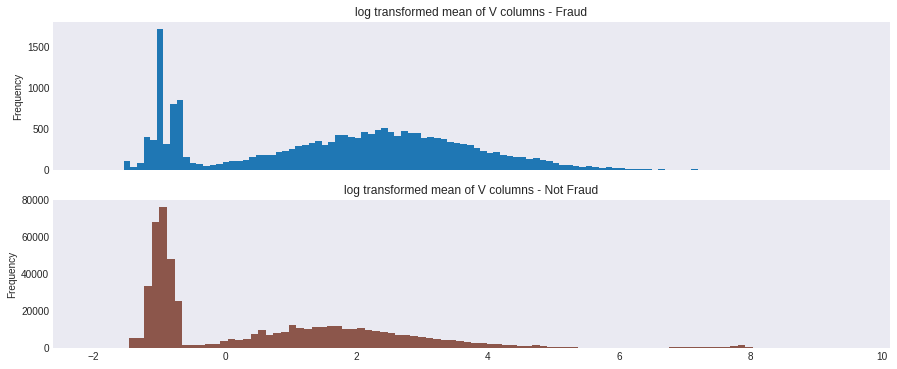

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 6))
train_transaction.loc[train_transaction['isFraud'] == 1]['v_mean'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='log transformed mean of V columns - Fraud',
          ax=ax1)
train_transaction.loc[train_transaction['isFraud'] == 0]['v_mean'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='log transformed mean of V columns - Not Fraud',
          color=color_pal[5],
          ax=ax2)
plt.show()

In [30]:
# Add the `isFraud` column for analysis
train_identity_ = train_identity.merge(train_transaction[['TransactionID',
                                                         'TransactionDT',
                                                         'isFraud']],
                                      on=['TransactionID'])

test_identity_ = test_identity.merge(test_transaction[['TransactionID',
                                                      'TransactionDT']],
                                    on=['TransactionID'])

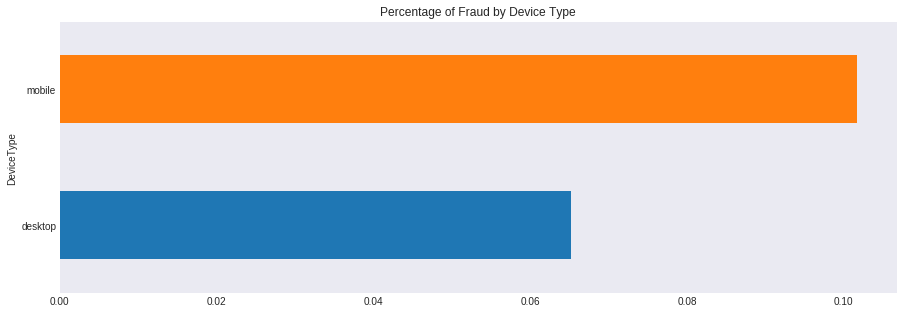

In [31]:
train_identity_.groupby('DeviceType')\
    .mean()['isFraud']\
    .sort_values()\
    .plot(kind='barh',
          figsize=(15, 5),
          title='Percentage of Fraud by Device Type')
plt.show()

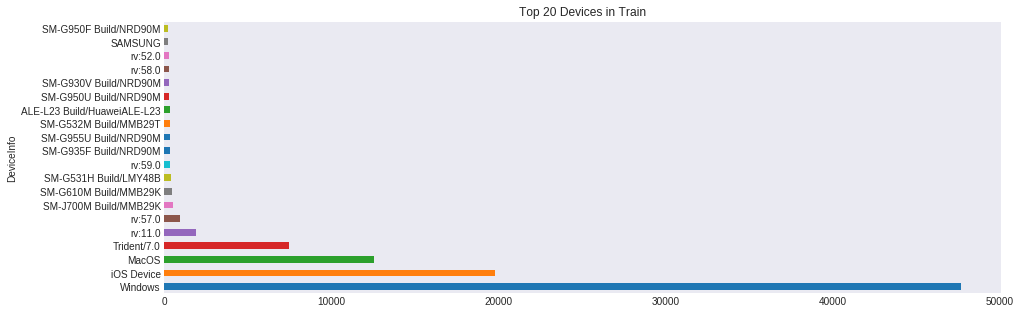

In [32]:
train_identity_.groupby('DeviceInfo').count()['TransactionID'] \
    .sort_values(ascending=False) \
    .head(20) \
    .plot(kind='barh', figsize=(15, 5), title='Top 20 Devices in Train')
plt.show()

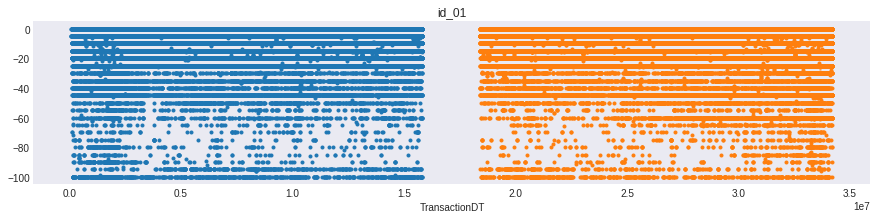

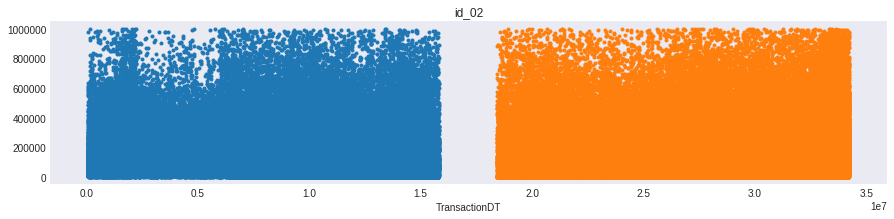

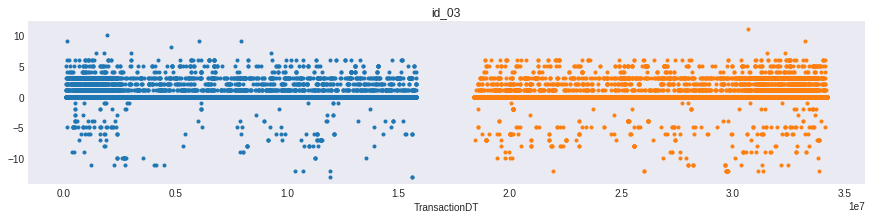

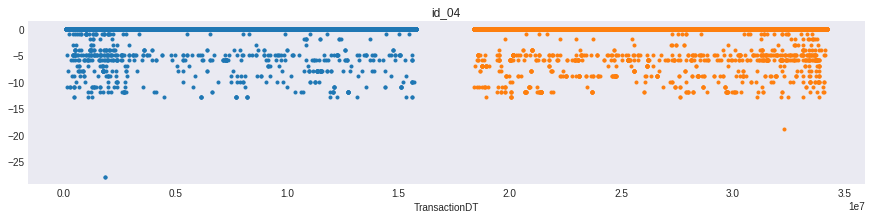

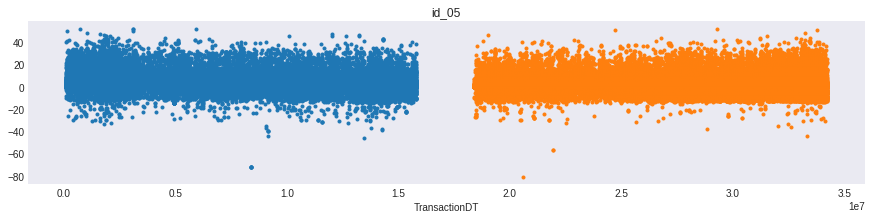

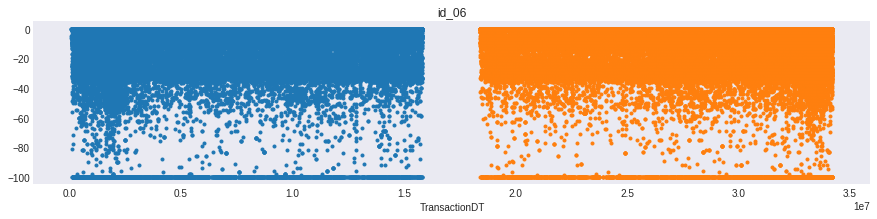

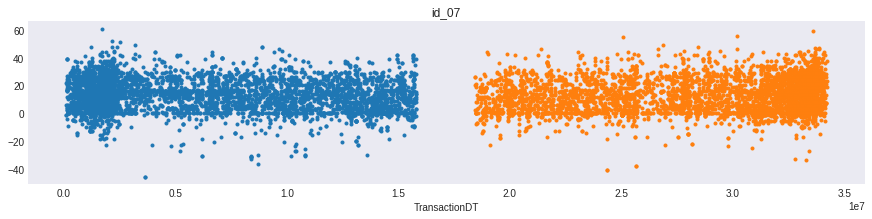

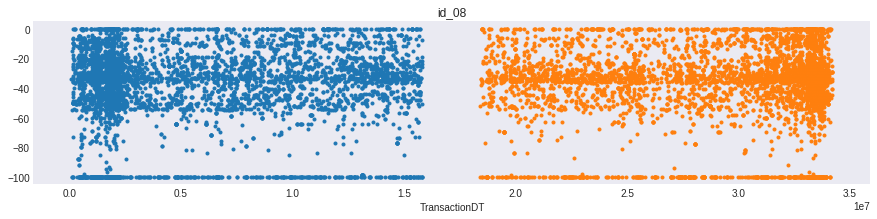

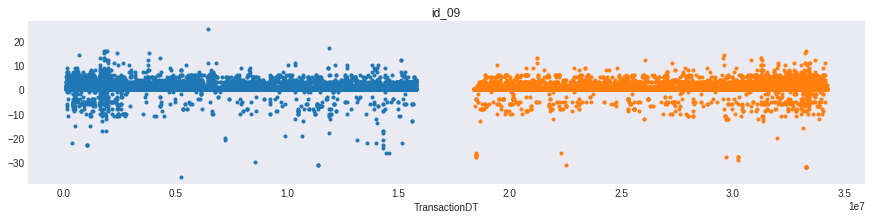

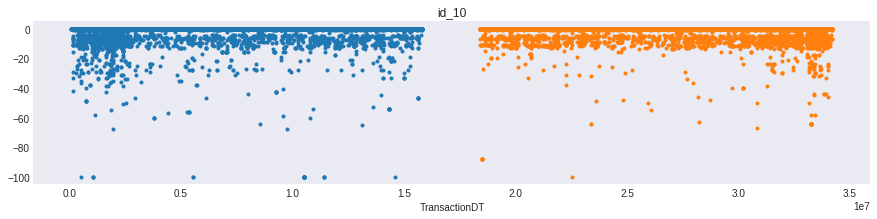

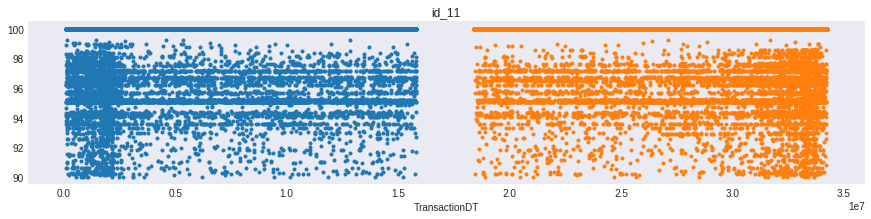

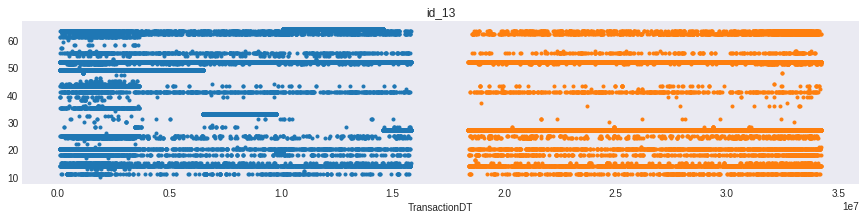

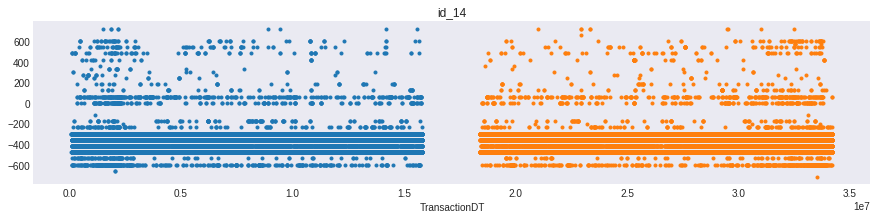

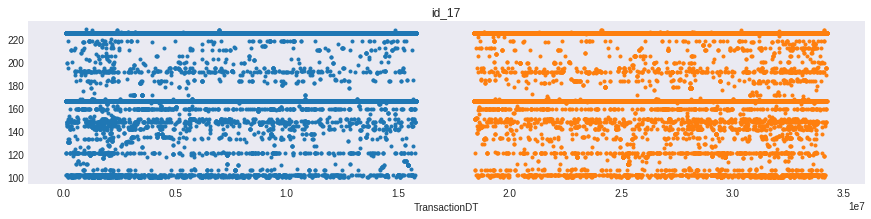

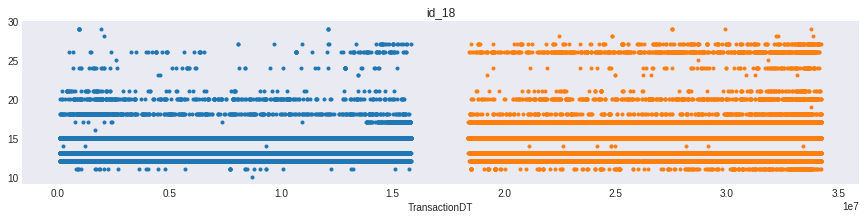

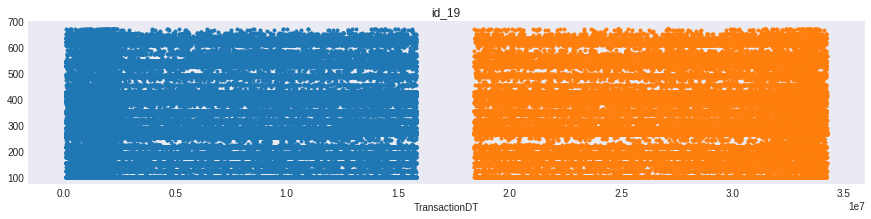

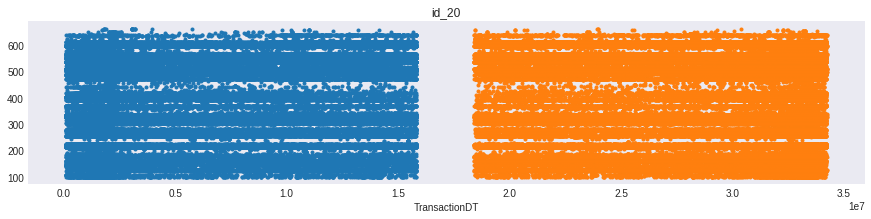

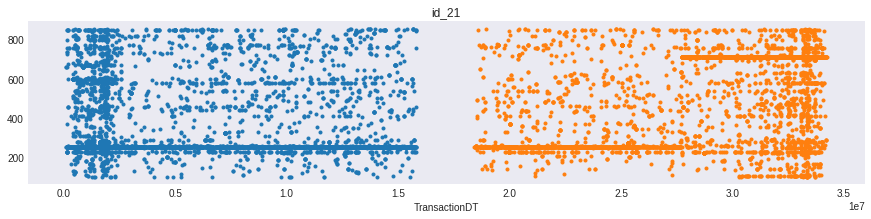

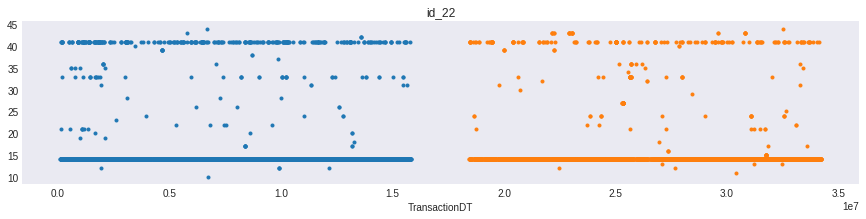

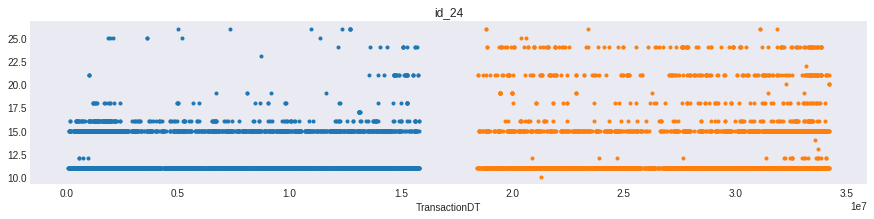

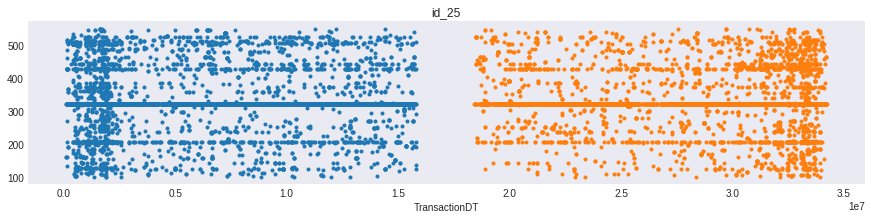

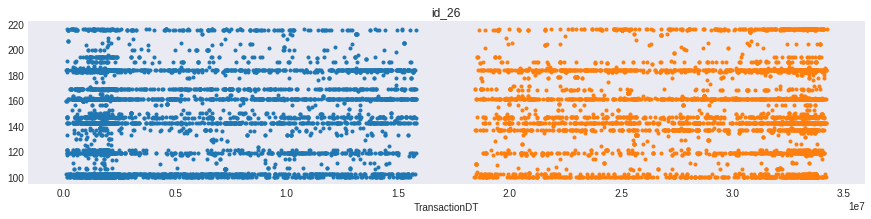

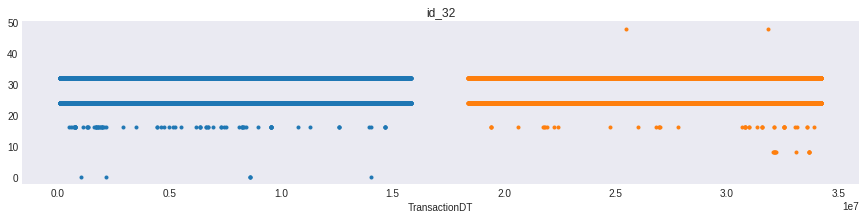

In [33]:
id_cols = [c for c in train_identity.columns if 'id' in c]
for i in id_cols:
    try:
        train_identity_.set_index('TransactionDT')[i].plot(style='.', title=i, figsize=(15, 3))
        test_identity_.set_index('TransactionDT')[i].plot(style='.', title=i, figsize=(15, 3))
        plt.show()
    except TypeError:
        pass

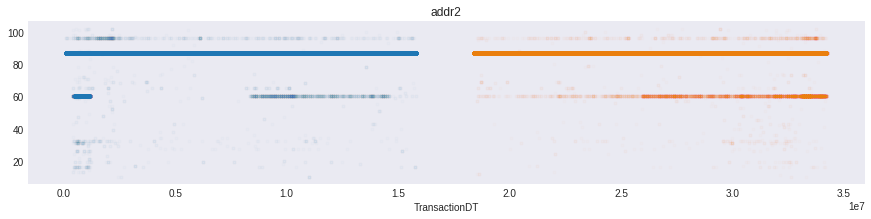

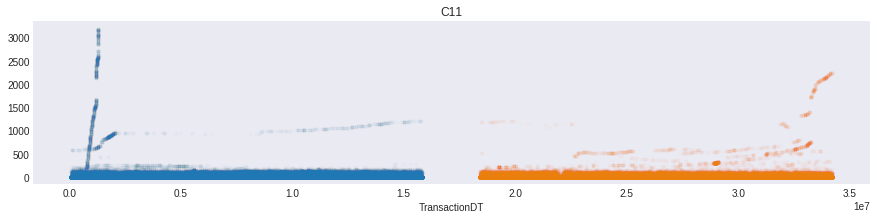

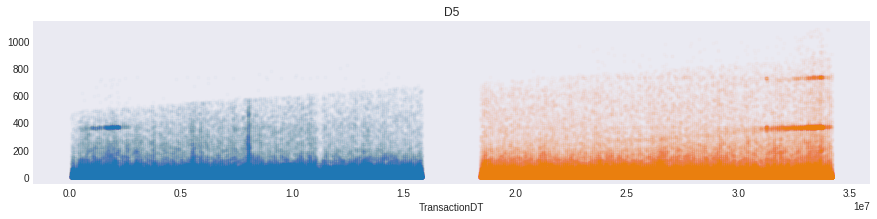

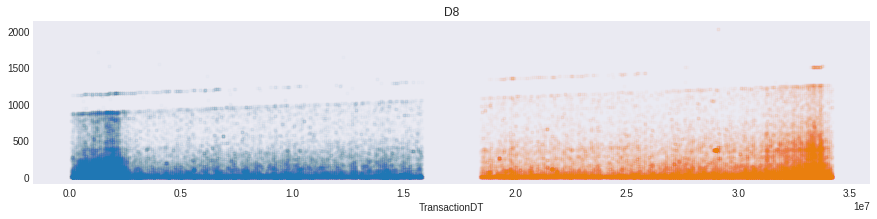

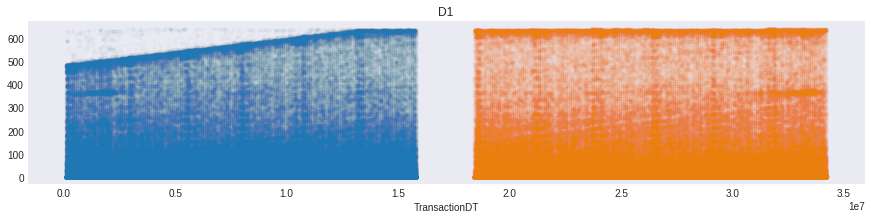

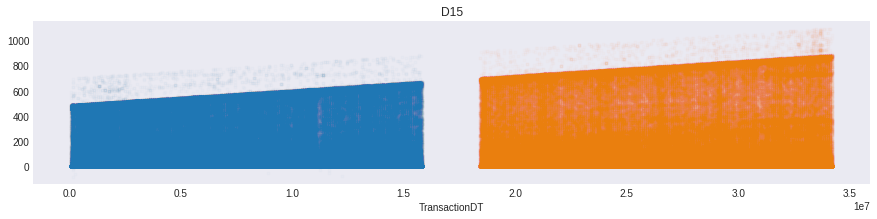

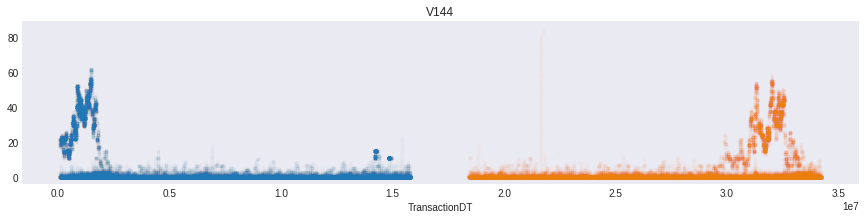

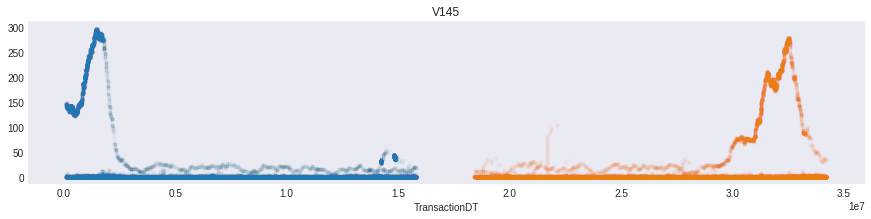

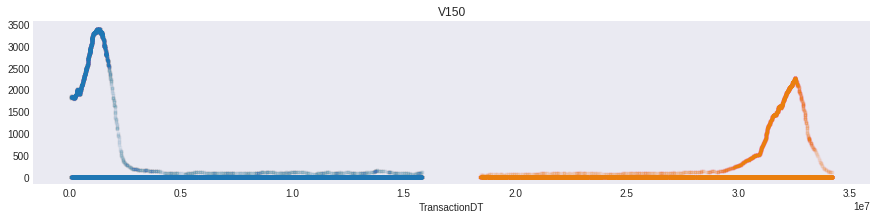

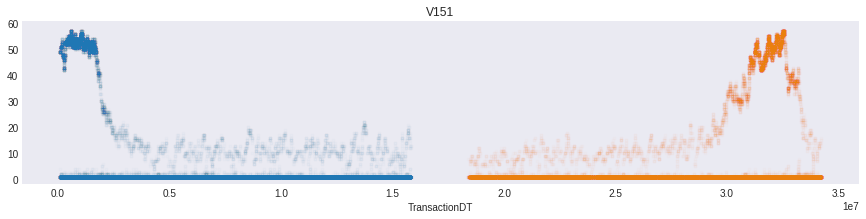

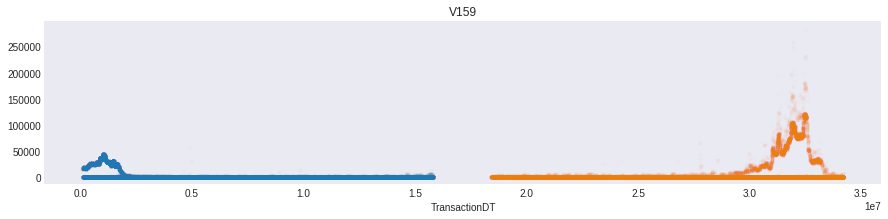

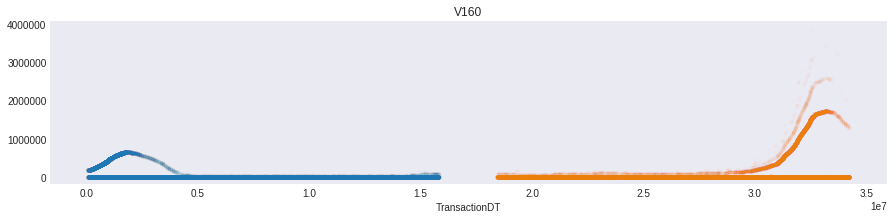

In [34]:
for c in ['addr2','C11','D5','D8','D1','D15','V144','V145','V150','V151','V159','V160']:
    try:
        train_transaction.set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3), alpha=0.01)
        test_transaction.set_index('TransactionDT')[c].plot(style='.', title=c, figsize=(15, 3), alpha=0.01)
        plt.show()
    except TypeError:
        pass
    except KeyError:
        pass